<style>.md-sidebar--secondary {display: none !important;}</style>

# ProBP


In [1]:
import passengersim as pax
pax.versions()

passengersim 0.11.2
passengersim.core 0.11.2.dev0+gab1f8db.d20230922


In [2]:
from passengersim.utils.codeview import show_file

In [3]:
# show_file("network/09-untrunc-em-high-demand.yaml")

In [4]:
cfg = pax.Config.from_yaml([
    "network/10-probp.yaml",
])

In [5]:
cfg.rm_systems['rm_probp'].steps

[UntruncationStep(name='untruncation', debug_filters=[], step_type='untruncation', kind='path', algorithm='em'),
 ForecastStep(name='path_forecast', debug_filters=[], step_type='forecast', algorithm='additive_pickup', kind='path', alpha=0.15),
 ProBpStep(name='optimization1', debug_filters=[], snapshot_filters=[], step_type='probp', kind='leg'),
 AggregationStep(name='aggregate', debug_filters=[], step_type='aggregation', legs_by_airline={}),
 EmsrStep(name='optimization2', debug_filters=[], snapshot_filters=[], step_type='emsr', kind='leg', algorithm='emsrb')]

In [6]:
cfg.simulation_controls.demand_multiplier

1.0

In [7]:
# cfg.simulation_controls.num_samples = 2
# cfg.simulation_controls.debug_availability = True

In [8]:
cfg.simulation_controls.num_trials = 1

In [9]:
cfg.simulation_controls.timeframe_demand_allocation

'pods'

In [10]:
if cfg.snapshot_filters:
    for sf in cfg.snapshot_filters:
        sf.directory = "snapshots"

In [11]:
cfg.db.write_items.add("leg")

In [12]:
sim = pax.Simulation(cfg)

In [13]:
summary = sim.run(log_reports=False)

In [14]:
summary.fig_carrier_revenues()

alt.LayerChart(...)

In [15]:
summary.fig_carrier_load_factors()

alt.LayerChart(...)

In [16]:
summary.fig_fare_class_mix()

alt.LayerChart(...)

In [17]:
summary.fig_bookings_by_timeframe()

alt.Chart(...)

In [18]:
# summary.to_xlsx("outputs/3mkt-10.xlsx")

## Comparing against Targets

In [19]:
import targets

target = targets.load(10)
target8 = targets.load(8)

In [20]:
from passengersim import contrast

In [21]:
contrast.fig_bookings_by_timeframe({
    "simulation": summary,
    "target": target,
    # "target8": target8,
}, by_carrier="AL1")

alt.Chart(...)

In [22]:
contrast.fig_carrier_revenues({
    "simulation": summary,
    "target": target,
    "target8": target8,
})

alt.FacetChart(...)

In [23]:
contrast.fig_carrier_load_factors({
    "simulation": summary,
    "target": target,
    "target8": target8,
})

alt.FacetChart(...)

In [24]:
contrast.fig_fare_class_mix({
    "simulation": summary,
    "target8": target8,
    "target": target,
})

alt.FacetChart(...)

In [37]:
contrast.fig_bookings_by_timeframe({
    "simulation": summary,
    "target": target,
    # "target8": target8,
}, by_carrier="AL1", by_class=True)

alt.FacetChart(...)

In [26]:
df = sim.cnx.dataframe("SELECT rrd, flt_no, MAX(bid_price) as avg_bid_price FROM leg_detail GROUP BY rrd, flt_no")
df = df[df.rrd > 0]

In [27]:
legs = sim.cnx.dataframe("SELECT trial, sample, rrd, flt_no, bid_price FROM leg_detail WHERE sample >= 100")
legs["trial"] = legs["trial"].astype("category")
legs

,trial,sample,rrd,flt_no,bid_price
0,0,100,63,101,14.415775
1,0,100,63,102,15.703421
2,0,100,63,201,21.584004
3,0,100,63,202,19.507365
4,0,100,63,111,107.084533
...,...,...,...,...,...
54395,0,499,0,202,0.000000
54396,0,499,0,111,0.000000
54397,0,499,0,112,0.000000
54398,0,499,0,211,0.000000


<Axes: xlabel='sample', ylabel='bid_price'>

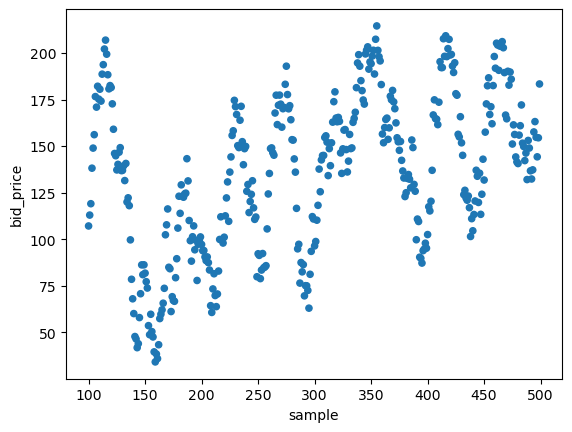

In [28]:
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green'}

legs_df = legs[(legs.rrd == 63) & (legs.flt_no == 111)]

legs_df.plot.scatter(
    y="bid_price", x="sample", c=legs_df['trial'].map(colors)
)

In [29]:
import pandas as pd
legs1 = pd.concat([
    legs.groupby(["rrd", "flt_no"]).bid_price.quantile(0.05).rename("low_bid_price"),
    legs.groupby(["rrd", "flt_no"]).bid_price.quantile(0.25).rename("lower_bid_price"),
    legs.groupby(["rrd", "flt_no"]).bid_price.quantile(0.5).rename("median_bid_price"),
    legs.groupby(["rrd", "flt_no"]).bid_price.quantile(0.75).rename("upper_bid_price"),
    legs.groupby(["rrd", "flt_no"]).bid_price.quantile(0.95).rename("high_bid_price"),
], axis=1).stack().rename("val").to_frame().reset_index()
#legs1 = legs1[legs1.rrd > 0]
legs1

,rrd,flt_no,level_2,val
0,0,101,low_bid_price,0.000000
1,0,101,lower_bid_price,0.000000
2,0,101,median_bid_price,0.000000
3,0,101,upper_bid_price,0.000000
4,0,101,high_bid_price,0.000000
...,...,...,...,...
675,63,212,low_bid_price,83.057751
676,63,212,lower_bid_price,117.473847
677,63,212,median_bid_price,148.564938
678,63,212,upper_bid_price,173.099746


In [30]:
import altair as alt

alt.Chart(legs1).mark_line(interpolate="step-before").encode(
    x=alt.X("rrd:Q").scale(reverse=True).title("Days from Departure"),
    y="val",
    color="level_2:N",
).facet(
    facet="flt_no:N",
    columns=3,
)

alt.FacetChart(...)

In [31]:
summary.fig_od_fare_class_mix('BOS', 'ORD')

alt.LayerChart(...)

In [32]:
summary.fig_od_fare_class_mix('BOS', 'LAX')

alt.LayerChart(...)

In [33]:
summary.fig_od_fare_class_mix('ORD', 'LAX')

alt.LayerChart(...)